# Guillaume Chacun

# Assignment 2 ATML 2020
## Classification with limited data

## Task 1. Implement ImageNetLimited class for data loading in datasets.py file

In [ ]:
# if using Google Colaboratory: upload the data as a zip file containing train, test and val folders then run this cell
#!unzip data.zip -d data

In [0]:
%load_ext autoreload
%autoreload 2
from datasets import ImageNetLimited

train_dir = 'data/train'
validation_dir = 'data/val'

In [0]:
import torch
torch.cuda.current_device()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# create datasets
train_dataset = ImageNetLimited(train_dir)
validation_dataset = ImageNetLimited(validation_dir)

In [0]:
from torchvision.transforms import Compose, ToTensor, Normalize, RandomHorizontalFlip, RandomVerticalFlip, RandomCrop, ColorJitter, RandomAffine, CenterCrop, Resize

train_transforms = Compose([
    RandomCrop(64),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize(mean=(0.5,), std=(0.5,))
])

test_transforms = Compose([
    CenterCrop(64),
    ToTensor(),
    Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset.set_transforms(train_transforms)
validation_dataset.set_transforms(test_transforms)

In [6]:
len(train_dataset.images), train_dataset.images[0].size, type(train_dataset.images[0])

(60000, (80, 80), PIL.Image.Image)

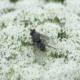

In [7]:
train_dataset.images[0]

In [0]:
# create dataloaders
from torch.utils.data import DataLoader
num_workers = 0
batch_size = 256

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

## Task 2. CNN Architecture

In [0]:
import torch.nn as nn

In [0]:
class ConvNet(nn.Module):
    
    def __init__(self, output_dim):
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()
        
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.relu5 = nn.ReLU()
        
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(in_features=8*8*256, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=output_dim)

        self._initialize_weights()
    
    def forward(self, input):
        output = self.conv1(input)
        output = self.relu1(output)
        
        output = self.conv2(output)
        output = self.relu2(output)

        output = self.pool1(output)
        output = self.bn1(output)

        output = self.conv3(output)
        output = self.relu3(output)

        output = self.pool2(output)
        output = self.bn2(output)

        output = self.conv4(output)
        output = self.relu4(output)

        output = self.conv5(output)
        output = self.relu5(output)

        output = self.pool3(output)

        output = output.view(output.size(0), -1)

        output = self.fc1(output)
        output = self.fc2(output)
        return output
      
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0) 

### Report - Architecture description

The Convolutional Neural Network structure used for this project is a reduced version of AlexNet's architecture. It contains five convolutional layers, three max pooling layers, 2 batch normalization layers and 2 fully connected layers. AlexNet was chosen because it is a commonly used architecture with many implementation examples online and good results on the ImageNet dataset.

<img src='./report_plots/model_architecture.png' alt='model architecture' width='800px'/>
<i style='display: block; text-align: center; font-size: 11px;'>Convolutional Neural Network's architecture used for this project.</i>
                                                                                    
Five convolutional layers are used as they provide the most gain in predictions' accuracy. They also are the most requiring computation wise. Five layers proved to be a good balance between the network's results and its training time (~1h on Google Colaboratory's GPUs). The kernel sizes are - like in VGG architectures - all 3x3 with paddings and strides of 1. The ReLU activation function is used as it guarantees no saturation of its gradient which therefore converges faster compared to other methods. 

The max pooling layers reduces the hidden-layers output matrices which improves training speed. It also encourages the model to make some assumptions about features contained in grouped sub-regions which helps with generalization. Combined with the batch normalization layers which also improve the speed, performance and stability of the network, the whole model trains reasonably fast and can reach ~68% accuracy on the training set and ~44% on the validation set after 50 epochs.

Note: this model has been slightly changed due to the findings of ablation n°1 presented in task 4.

## Task 3. Train Model

In [0]:
# initialize parameters, model, optimizer and loss function
import numpy as np
from torch.optim import Adam, Adagrad
from torch.optim.lr_scheduler import ReduceLROnPlateau

# set parameters
n_epochs = 50
learning_rate = 0.001
weight_decay = 0.0001

input_shape = (3, 64, 64)
input_dim = np.prod(input_shape)
output_dim = 100

# initialize model
model = ConvNet(output_dim)
model = model.to(device)

# initialize optimizer and loss function
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_fn = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, patience=5, verbose=True)

In [0]:
import statistics
def train_epoch(model, train_dataloader, optimizer, loss_fn, verbose=True):
    losses = []
    correct_predictions = 0
    
    model.train() # switch model to training mode
    
    for iteration, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device, dtype=torch.int64)
        
        # compute outputs
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        
        # gradient & optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # save metrics
        losses.append(loss.item())
        correct_predictions += (outputs.argmax(dim=1) == labels).sum().item()
        
        if verbose and iteration % 16 == 0:
            print('Training iteration {}: loss {:.4f}'.format(iteration, loss.item()))
            
    # compute & print statistics
    average_loss = statistics.mean(losses)
    accuracy = 100.0 * correct_predictions / len(train_dataloader.dataset)
    if verbose:
        print(f'Train average loss: {round(average_loss,4)}, accuracy: {round(accuracy,3)}')
    return average_loss, accuracy

In [0]:
def evaluate(model, val_dataloader, loss_fn, validation=True, output_results=False, verbose=True):
    losses = []
    correct_predictions = 0
    outputs_list = []
    
    model.eval() # switch model to test mode
    
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device, dtype=torch.int64)

            # predict & compute loss
            outputs = model(images)
            if validation:
                loss = loss_fn(outputs, labels)
            
            if output_results:
                # store each image, label and prediction
                outputs_list += [(idx+1, img, label, output.argmax()) for idx, (img, label, output) in enumerate(zip(images, labels, outputs))]
                
            # save metrics
            if validation:
                losses.append(loss.item())
                correct_predictions += (outputs.argmax(dim=1) == labels).sum().item()

    # compute & print statistics
    if validation:
        average_loss = statistics.mean(losses)
        accuracy = 100.0 * correct_predictions / len(val_dataloader.dataset)
        if verbose:
            print(f'Validation average loss: {round(average_loss,4)}, accuracy: {round(accuracy,3)}')
        return average_loss, accuracy, outputs_list
    return None, None, outputs_list

In [0]:
import time
def train(model, train_dataloader, val_dataloader, optimizer, loss_fn, scheduler, n_epochs, start_scheduler_after=0, verbose=True):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    start_training_time = time.time()
    for epoch in range(n_epochs):
        if verbose:
            print('Epoch {}'.format(epoch+1))

        # train
        train_loss, train_accuracy = train_epoch(model, train_dataloader, optimizer, loss_fn, verbose=verbose)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # validation
        val_loss, val_accuracy, _ = evaluate(model, val_dataloader, loss_fn, verbose=verbose)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        # adjust learning rate
        if epoch >= start_scheduler_after:
            scheduler.step(val_loss)
    
    # display time elapsed
    time_elapsed = time.time() - start_training_time
    hours = time_elapsed // 3600
    minutes = (time_elapsed - 3600 * hours) // 60
    print(f'Training took {hours} hour(s) and {minutes} minute(s)')
    return train_losses, train_accuracies, val_losses, val_accuracies

In [ ]:
# train the model
train_losses, train_accuracies, val_losses, val_accuracies = train(model, 
                                                                   train_dataloader, val_dataloader, 
                                                                   optimizer, loss_fn, scheduler,
                                                                   n_epochs, start_scheduler_after=15)

In [0]:
print(f'Average loss & accuracy after last training epoch (n° {n_epochs}):')
print(f'Train average loss: {round(train_losses[-1],4)}, accuracy: {round(train_accuracies[-1],4)}')
print(f'Validation average loss: {round(val_losses[-1],4)}, accuracy: {round(val_accuracies[-1],4)}')

Average loss & accuracy after last training epoch (n° 50):
Train average loss: 1.0992, accuracy: 68.2517
Validation average loss: 2.3229, accuracy: 44.4884


In [0]:
import matplotlib.pyplot as plt
def plot(n_epochs, train_losses, val_losses, train_accuracies, val_accuracies, plot_validation=True):
    fig, axs = plt.subplots(ncols=2, figsize=(15,6))
    
    # losses
    axs[0].plot(np.arange(n_epochs), train_losses)
    if plot_validation:
        axs[0].plot(np.arange(n_epochs), val_losses)
        axs[0].legend(['train_loss', 'val_loss'])
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss value')
    axs[0].title.set_text('Train/val loss' if plot_validation else 'Train loss')

    # accuracies
    axs[1].plot(np.arange(n_epochs), train_accuracies)
    if plot_validation:
        axs[1].plot(np.arange(n_epochs), val_accuracies)
        axs[1].legend(['train_acc', 'val_acc'])
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('accuracy')
    axs[1].title.set_text('Train/val accuracy' if plot_validation else 'Train accuracy')

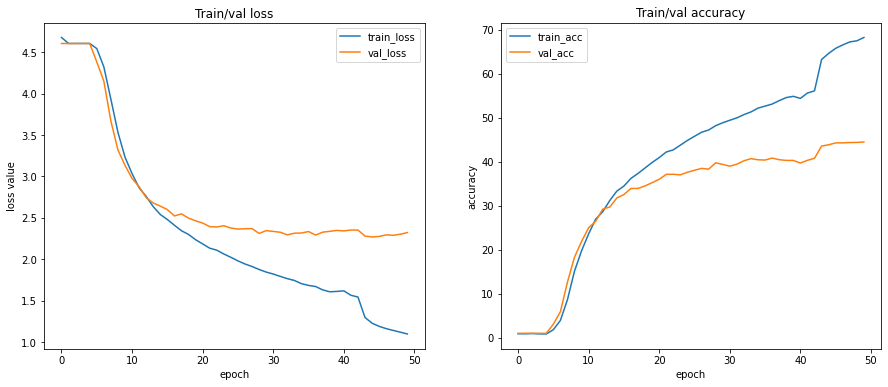

In [0]:
# plot training curves
plot(n_epochs, train_losses, val_losses, train_accuracies, val_accuracies)

In [0]:
# clear memory
model = optimizer = None
del model
del optimizer
torch.cuda.empty_cache()

# test the model

## Task 4. Ablations

Note: below you will find first the code to run each individual ablation. Then, in section 3.1.7, the performances of each model are presented and briefly commented. The final model and its hyperparameters are described in section 3.1.8.

### Ablation n°1 (network's architecture & dropout)

In [0]:
class ConvNetModified(nn.Module):
    
    def __init__(self, output_dim):
        super(ConvNetModified, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()
        
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.relu5 = nn.ReLU()
        
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout1 = nn.Dropout(p=0.3)
        self.fc1 = nn.Linear(in_features=8*8*256, out_features=1024)
        self.dropout2 = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(in_features=1024, out_features=512)
        self.dropout3 = nn.Dropout(p=0.3)
        self.fc3 = nn.Linear(in_features=512, out_features=output_dim)

        self._initialize_weights()
    
    def forward(self, input):
        output = self.conv1(input)
        output = self.relu1(output)
        
        output = self.conv2(output)
        output = self.relu2(output)

        output = self.pool1(output)
        output = self.bn1(output)

        output = self.conv3(output)
        output = self.relu3(output)

        output = self.pool2(output)
        output = self.bn2(output)

        output = self.conv4(output)
        output = self.relu4(output)

        output = self.conv5(output)
        output = self.relu5(output)

        output = self.pool3(output)

        output = output.view(output.size(0), -1)

        output = self.dropout1(output)
        output = self.fc1(output)
        output = self.dropout2(output)
        output = self.fc2(output)
        output = self.dropout3(output)
        output = self.fc3(output)

        return output
      
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0) 

In [0]:
# dataloaders
train_dataloader_ab1 = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader_ab1 = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [0]:
# set parameters
n_epochs_ab1 = 70

# initialize model
model_ab1 = ConvNetModified(output_dim) # ConvNet in Original model
model_ab1 = model_ab1.to(device)

# initialize optimizer and loss function
optimizer_ab1 = Adam(model_ab1.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_fn_ab1 = nn.CrossEntropyLoss()
scheduler_ab1 = ReduceLROnPlateau(optimizer_ab1, patience=5, verbose=True)

In [ ]:
# train ablation model 1
train_losses_ab1, train_accuracies_ab1, val_losses_ab1, val_accuracies_ab1 = train(model_ab1, 
                                                                                   train_dataloader_ab1, val_dataloader_ab1, 
                                                                                   optimizer_ab1, loss_fn_ab1, scheduler_ab1,
                                                                                   n_epochs_ab1, start_scheduler_after=15, verbose=True)

Average loss & accuracy after last training epoch (n° 90):
Train average loss: 1.251, accuracy: 62.7267
Validation average loss: 1.9381, accuracy: 49.5059


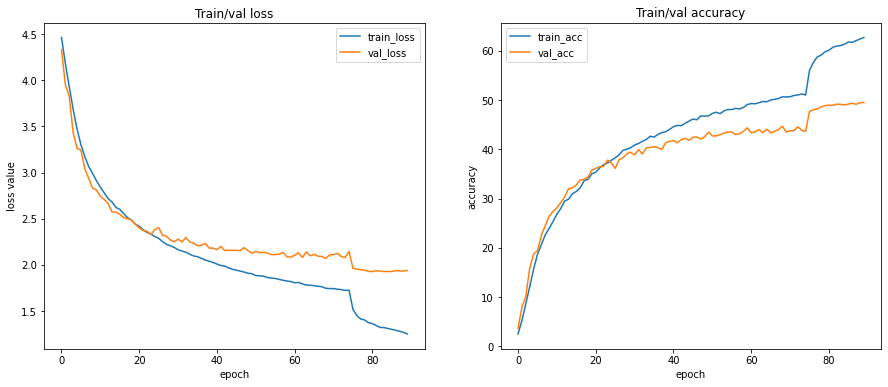

In [0]:
# model's performances & training curves
print(f'Average loss & accuracy after last training epoch (n° {n_epochs_ab1}):')
print(f'Train average loss: {round(train_losses_ab1[-1],4)}, accuracy: {round(train_accuracies_ab1[-1],4)}')
print(f'Validation average loss: {round(val_losses_ab1[-1],4)}, accuracy: {round(val_accuracies_ab1[-1],4)}')
plot(n_epochs_ab1, train_losses_ab1, val_losses_ab1, train_accuracies_ab1, val_accuracies_ab1)

In [0]:
# clear memory
model_ab1 = optimizer_ab1 = None
del model_ab1
del optimizer_ab1
torch.cuda.empty_cache()

### Ablation n°2 (optimizer)

In [0]:
# dataloaders
train_dataloader_ab2 = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader_ab2 = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [0]:
# set parameters
n_epochs_ab2 = 40
learning_rate_ab2 = 0.001

# initialize model
model_ab2 = ConvNetModified(output_dim) # ConvNet in Original model
model_ab2 = model_ab2.to(device)

# initialize optimizer
optimizer_ab2 = Adagrad(model_ab2.parameters(), lr=learning_rate_ab2) # Adam in Original model
loss_fn_ab2 = nn.CrossEntropyLoss()
scheduler_ab2 = ReduceLROnPlateau(optimizer_ab2, patience=5, verbose=True)

In [ ]:
train_losses_ab2, train_accuracies_ab2, val_losses_ab2, val_accuracies_ab2 = train(model_ab2, 
                                                                                   train_dataloader_ab2, val_dataloader_ab2, 
                                                                                   optimizer_ab2, loss_fn_ab2, scheduler_ab2,
                                                                                   n_epochs_ab2, start_scheduler_after=15, verbose=True)

Average loss & accuracy after last training epoch (n° 40):
Train average loss: 2.6654, accuracy: 31.6317
Validation average loss: 2.7036, accuracy: 31.2778


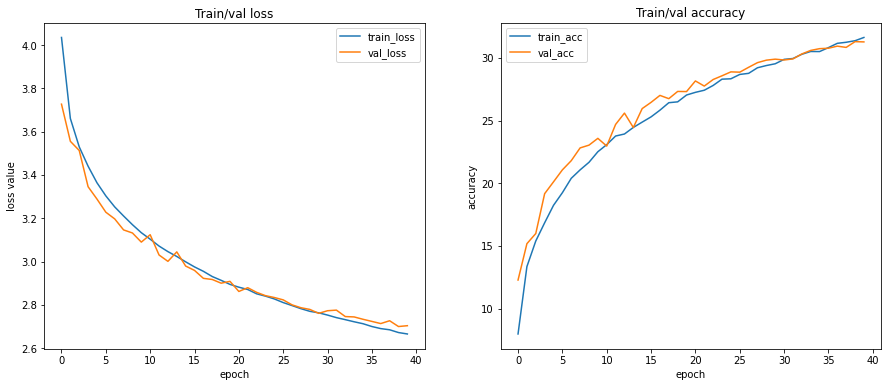

In [0]:
# model's performances & training curves
print(f'Average loss & accuracy after last training epoch (n° {n_epochs_ab2}):')
print(f'Train average loss: {round(train_losses_ab2[-1],4)}, accuracy: {round(train_accuracies_ab2[-1],4)}')
print(f'Validation average loss: {round(val_losses_ab2[-1],4)}, accuracy: {round(val_accuracies_ab2[-1],4)}')
plot(n_epochs_ab2, train_losses_ab2, val_losses_ab2, train_accuracies_ab2, val_accuracies_ab2)

In [0]:
# clear memory
model_ab2 = optimizer_ab2 = None
del model_ab2
del optimizer_ab2
torch.cuda.empty_cache()

### Ablation n°3 (learning rate & weight decay)

In [0]:
# dataloaders
train_dataloader_ab3 = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader_ab3 = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [0]:
# set parameters
n_epochs_ab3 = 50
learning_rate_ab3 = 0.005 # 0.001 in Original model
weight_decay_ab3 = 0.00005 # 0.0001 in Original model

# initialize model
model_ab3 = ConvNetModified(output_dim)
model_ab3 = model_ab3.to(device)

# initialize optimizer
optimizer_ab3 = Adam(model_ab3.parameters(), lr=learning_rate_ab3, weight_decay=weight_decay_ab3)
loss_fn_ab3 = nn.CrossEntropyLoss()
scheduler_ab3 = ReduceLROnPlateau(optimizer_ab3, patience=5, verbose=True)

In [ ]:
train_losses_ab3, train_accuracies_ab3, val_losses_ab3, val_accuracies_ab3 = train(model_ab3, 
                                                                                   train_dataloader_ab3, val_dataloader_ab3, 
                                                                                   optimizer_ab3, loss_fn_ab3, scheduler_ab3,
                                                                                   n_epochs_ab3, verbose=True)

Average loss & accuracy after last training epoch (n° 50):
Train average loss: 4.6576, accuracy: 1.0133
Validation average loss: 4.649, accuracy: 1.0049


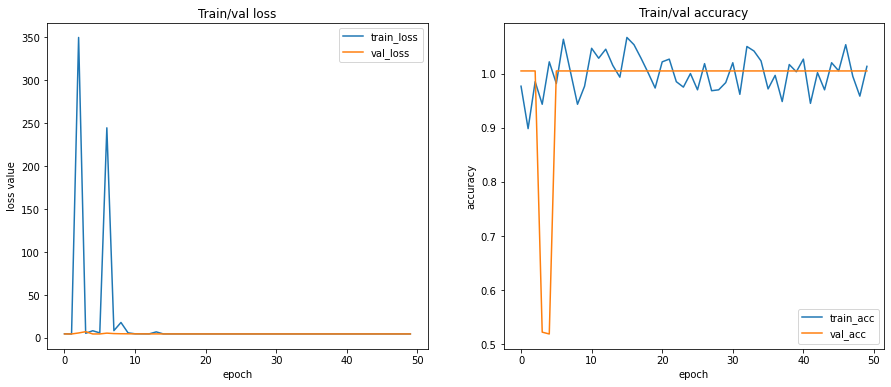

In [0]:
# model's performances & training curves
print(f'Average loss & accuracy after last training epoch (n° {n_epochs_ab3}):')
print(f'Train average loss: {round(train_losses_ab3[-1],4)}, accuracy: {round(train_accuracies_ab3[-1],4)}')
print(f'Validation average loss: {round(val_losses_ab3[-1],4)}, accuracy: {round(val_accuracies_ab3[-1],4)}')
plot(n_epochs_ab3, train_losses_ab3, val_losses_ab3, train_accuracies_ab3, val_accuracies_ab3)

In [0]:
# clear memory
model_ab3 = optimizer_ab3 = None
del model_ab3
del optimizer_ab3
torch.cuda.empty_cache()

### Ablation n°4 (loss function)

In [0]:
# dataloaders
train_dataloader_ab4 = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader_ab4 = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [0]:
# set parameters
n_epochs_ab4 = 25

# initialize model
model_ab4 = ConvNetModified(output_dim)
model_ab4 = model_ab4.to(device)

# initialize optimizer & loss function
optimizer_ab4 = Adam(model_ab4.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_fn_ab4 = nn.NLLLoss() # CrossEntropyLoss in Original model
scheduler_ab4 = ReduceLROnPlateau(optimizer_ab4, patience=5, verbose=True)

In [ ]:
train_losses_ab4, train_accuracies_ab4, val_losses_ab4, val_accuracies_ab4 = train(model_ab4, 
                                                                                   train_dataloader_ab4, val_dataloader_ab4, 
                                                                                   optimizer_ab4, loss_fn_ab4, scheduler_ab4,
                                                                                   n_epochs_ab4, verbose=True)

Average loss & accuracy after last training epoch (n° 25):
Train average loss: -3.4080871572559874e+22, accuracy: 0.9933
Validation average loss: -3.7660457284236715e+22, accuracy: 1.0049


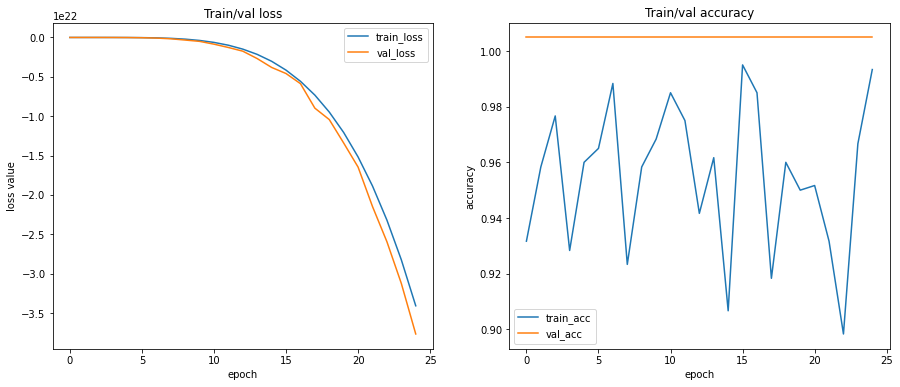

In [0]:
# model's performances & training curves
print(f'Average loss & accuracy after last training epoch (n° {n_epochs_ab4}):')
print(f'Train average loss: {round(train_losses_ab4[-1],4)}, accuracy: {round(train_accuracies_ab4[-1],4)}')
print(f'Validation average loss: {round(val_losses_ab4[-1],4)}, accuracy: {round(val_accuracies_ab4[-1],4)}')
plot(n_epochs_ab4, train_losses_ab4, val_losses_ab4, train_accuracies_ab4, val_accuracies_ab4)

In [0]:
# clear memory
model_ab4 = optimizer_ab4 = None
del model_ab4
del optimizer_ab4
torch.cuda.empty_cache()

### Ablation n°5 (batch size)

In [0]:
batch_size_ab5 = 512 # 256 in Original model

# dataloaders
train_dataloader_ab5 = DataLoader(train_dataset, batch_size=batch_size_ab5, shuffle=True, num_workers=num_workers)
val_dataloader_ab5 = DataLoader(validation_dataset, batch_size=batch_size_ab5, shuffle=True, num_workers=num_workers)

In [0]:
# set parameters
n_epochs_ab5 = 60

# initialize model
model_ab5 = ConvNetModified(output_dim)
model_ab5 = model_ab5.to(device)

# initialize optimizer & loss function
optimizer_ab5 = Adam(model_ab5.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_fn_ab5 = nn.CrossEntropyLoss()
scheduler_ab5 = ReduceLROnPlateau(optimizer_ab5, patience=5, verbose=True)

In [ ]:
train_losses_ab5, train_accuracies_ab5, val_losses_ab5, val_accuracies_ab5 = train(model_ab5, 
                                                                                   train_dataloader_ab5, val_dataloader_ab5, 
                                                                                   optimizer_ab5, loss_fn_ab5, scheduler_ab5,
                                                                                   n_epochs_ab5, start_scheduler_after=15, verbose=True)

Average loss & accuracy after last training epoch (n° 60):
Train average loss: 1.499, accuracy: 56.6017
Validation average loss: 1.9945, accuracy: 46.7459


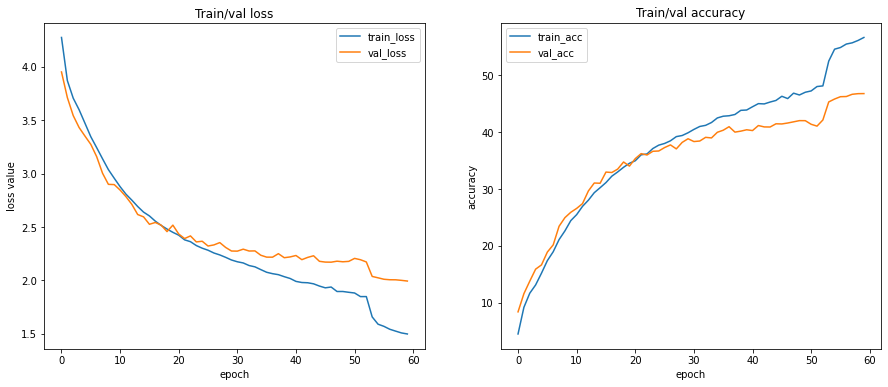

In [0]:
# model's performances & training curves
print(f'Average loss & accuracy after last training epoch (n° {n_epochs_ab5}):')
print(f'Train average loss: {round(train_losses_ab5[-1],4)}, accuracy: {round(train_accuracies_ab5[-1],4)}')
print(f'Validation average loss: {round(val_losses_ab5[-1],4)}, accuracy: {round(val_accuracies_ab5[-1],4)}')
plot(n_epochs_ab5, train_losses_ab5, val_losses_ab5, train_accuracies_ab5, val_accuracies_ab5)

In [0]:
# clear memory
model_ab5 = optimizer_ab5 = None
del model_ab5
del optimizer_ab5
torch.cuda.empty_cache()

### Ablation n°6 (data augmentation)

In [0]:
train_transforms_ab6 = Compose([
    RandomCrop(64),
    RandomHorizontalFlip(),
    RandomVerticalFlip(), # not used in Original model
    RandomAffine(degrees=90), # not used in Original model
    ToTensor(),
    Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset.set_transforms(train_transforms_ab6)

In [0]:
# dataloaders
train_dataloader_ab6 = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader_ab6 = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [0]:
# set parameters
n_epochs_ab6 = 60

# initialize model
model_ab6 = ConvNetModified(output_dim)
model_ab6 = model_ab6.to(device)

# initialize optimizer
optimizer_ab6 = Adam(model_ab6.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_fn_ab6 = nn.CrossEntropyLoss()
scheduler_ab6 = ReduceLROnPlateau(optimizer_ab6, patience=5, verbose=True)

In [ ]:
train_losses_ab6, train_accuracies_ab6, val_losses_ab6, val_accuracies_ab6 = train(model_ab6, 
                                                                                   train_dataloader_ab6, val_dataloader_ab6, 
                                                                                   optimizer_ab6, loss_fn_ab6, scheduler_ab6,
                                                                                   n_epochs_ab6, start_scheduler_after=15, verbose=True)

Average loss & accuracy after last training epoch (n° 60):
Train average loss: 2.8811, accuracy: 26.8617
Validation average loss: 2.7805, accuracy: 28.5614


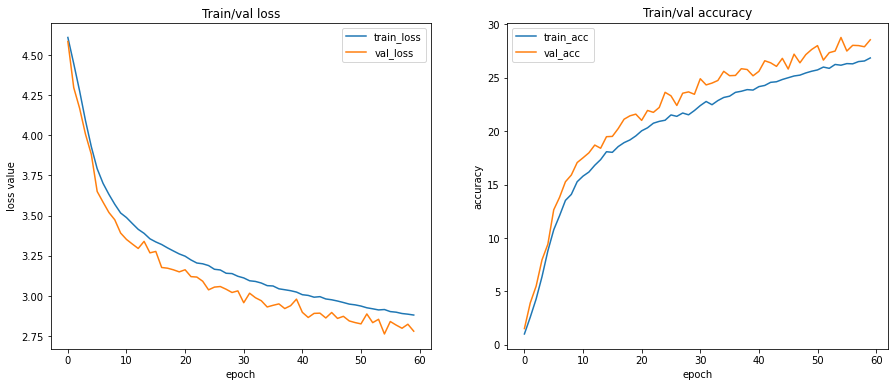

In [0]:
# model's performances & training curves
print(f'Average loss & accuracy after last training epoch (n° {n_epochs_ab6}):')
print(f'Train average loss: {round(train_losses_ab6[-1],4)}, accuracy: {round(train_accuracies_ab6[-1],4)}')
print(f'Validation average loss: {round(val_losses_ab6[-1],4)}, accuracy: {round(val_accuracies_ab6[-1],4)}')
plot(n_epochs_ab6, train_losses_ab6, val_losses_ab6, train_accuracies_ab6, val_accuracies_ab6)

In [0]:
# clear memory
model_ab6 = optimizer_ab6 = None
del model_ab6
del optimizer_ab6
torch.cuda.empty_cache()

<hr>

### Report - ablations

#### Original model

- Network architecture: ConvNet
- Number of epochs: 50
- Data augmentation: RandomCrop(64), RandomHorizontalFlip()
- Batch size: 256
- Optimizer: Adam
- Learning rate: 0.001
- Weight decay: 0.0001
- Loss function: CrossEntropyLoss

<img src='./report_plots/original_learningcurves.png' alt="Original model's learning curves" width='800px'/>
<i style='display: block; text-align: center; font-size: 11px;'>Original model's learning curves.</i>

<u>Results:</u>
- Training time: 1h2m (50 epochs)
- Train average loss: 1.0992, accuracy: 68.2517
- Validation average loss: 2.3229, accuracy: 44.4884

#### Ablation n°1 (network's architecture & dropout)

- Add fully connected layer (512)
- Add Dropout (p=0.3) between every fully connected layers.

<img src='./report_plots/ablation1_learningcurves.png' alt="Ablation n°1 model's learning curves" width='800px'/>
<i style='display: block; text-align: center; font-size: 11px;'>Ablation n°1 model's learning curves.</i>

<u>Results:</u>
- Training time: 1h53m (90 epochs)
- Train average loss: 1.251, accuracy: 62.7267
- Validation average loss: 1.9381, accuracy: 49.5059

<u>Comments:</u>
<p>The modified architecture presented in the figure below gives better accuracy on the validation set with 49% for 44% with the previous network. The dropout seems to help generalize the learning but it also requires more time for training.</p>

<table>
  <tr style='background-color:white;'>
    <td>
      <img src='./report_plots/model_architecture_table.png' alt='original model architecture' width='300px'/>
    </td>
    <td>
      <img src='./report_plots/modified_model_architecture_table.png' alt='modified model architecture' width='300px'/>
    </td>
  </tr>
  <tr>
    <td colspan="2">
      <i style='display: block; text-align: center; font-size: 11px;'>Original Convolutional Neural Network architecture (left) and its modified version which proved to give better accuracy on the validation set (right).</i>
    </td>
  </tr>
</table>

#### Ablation n°2 (optimizer)

- Optimizer: Adagrad
- Learning rate: 0.001

<img src='./report_plots/ablation2_learningcurves.png' alt="Ablation n°2 model's learning curves" width='800px'/>
<i style='display: block; text-align: center; font-size: 11px;'>Ablation n°2 model's learning curves.</i>

<u>Results:</u>
- Training time: 49m (40 epochs)
- Train average loss: 2.6654, accuracy: 31.6317
- Validation average loss: 2.7036, accuracy: 31.2778

<u>Comments:</u>
<p>The Adagrad optimizer seems less efficient than Adam for this problem. The accuracy on the validation set is approximately 10% lower than with Adam at epoch 40.</p>

#### Ablation n°3 (learning rate & weight decay)

- Learning rate: 0.005
- Weight decay: 0.00005

<img src='./report_plots/ablation3_learningcurves.png' alt="Ablation n°3 model's learning curves" width='800px'/>
<i style='display: block; text-align: center; font-size: 11px;'>Ablation n°3 model's learning curves.</i>

<u>Results:</u>
- Training time: 1h1m (50 epochs)
- Train average loss: 4.6576, accuracy: 1.0133
- Validation average loss: 4.649, accuracy: 1.0049

<u>Comments:</u>
<p>Learning rates higher than 0.001 seem to give poor results with Adam - the model is not learning anything. Lower learning rates allow for some learning but not as efficiently than with lr=0.001. Similar observations for the weight decay parameter.</p>

#### Ablation n°4 (loss function)

- Loss function: NLLLoss

<img src='./report_plots/ablation4_learningcurves.png' alt="Ablation n°4 model's learning curves" width='800px'/>
<i style='display: block; text-align: center; font-size: 11px;'>Ablation n°4 model's learning curves.</i>

<u>Results:</u>
- Training time: 30m (25 epochs)
- Train average loss: -3.4080871572559874e+22, accuracy: 0.9933
- Validation average loss: -3.7660457284236715e+22, accuracy: 1.0049

<u>Comments:</u>
<p>The NLLLoss slightly decreases with time but the model is not able to learn anything relevant as the accuracy stagnates around 1%.</p>

#### Ablation n°5 (batch size)

- Batch size: 128

<img src='./report_plots/ablation5_learningcurves.png' alt="Ablation n°5 model's learning curves (batch size=128)" width='800px'/>
<i style='display: block; text-align: center; font-size: 11px;'>Ablation n°5 model's learning curves (batch size=128).</i>

<u>Results:</u>
- Training time: 46m (60 epochs)
- Train average loss: 1.9243, accuracy: 46.8767
- Validation average loss: 2.0717, accuracy: 43.2222

<hr>

- Batch size: 512

<img src='./report_plots/ablation5_2_learningcurves.png' alt="Ablation n°5 model's learning curves (batch size=512)" width='800px'/>
<i style='display: block; text-align: center; font-size: 11px;'>Ablation n°5 model's learning curves (batch size=512).</i>

<u>Results:</u>
- Training time: 57m (60 epochs)
- Train average loss: 1.499, accuracy: 56.6017
- Validation average loss: 1.9945, accuracy: 46.7459

<u>Comments:</u>
<p>Smaller batch sizes produce more noise in the parameters as the loss is computed over less data. This noise can, however, help with generalization of the model. This is what's observed on the learning curves with a batch size of 128. The training and validation losses are similar up to ~2.25 and an accuracy of ~43%. For a batch size of 256, the losses are similar up to ~2.5 and an accuracy of ~38%. This shows a better generalization of the model but lower overall accuracy.</p>

#### Ablation n°6 (data augmentation)

- Data augmentation: RandomCrop(64), RandomHorizontalFlip(), RandomVerticalFlip(), RandomAffine(degrees=90)

<img src='./report_plots/ablation6_learningcurves.png' alt="Ablation n°6 model's learning curves" width='800px'/>
<i style='display: block; text-align: center; font-size: 11px;'>Ablation n°6 model's learning curves.</i>

<u>Results:</u>
- Training time: 55m (60 epochs)
- Train average loss: 2.8811, accuracy: 26.8617
- Validation average loss: 2.7805, accuracy: 28.5614

<u>Comments:</u>
<p>The two added transformations seem to penalize the learning of the model (28% accuracy on the validation set after 60 epochs). It is possible than with more time, the model could achieve - or even outperform - the original model's performances. </p>

### Best model

#### Report - best model

<p>With respect to the findings of the ablations' study, hereby follows the final model design & hyperparameters:</p>

- Network architecture: ConvNetModified (described in section 3.1.7.2)
- Number of epochs: 100
- Data augmentation: RandomCrop(64), RandomHorizontalFlip()
- Batch size: 256
- Optimizer: Adam
- Learning rate: 0.001
- Weight decay: 0.0001
- Loss function: CrossEntropyLoss

#### Training the final model

In [ ]:
train_transforms_fm = Compose([
    RandomCrop(64),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset.set_transforms(train_transforms_fm)

# dataloaders
batch_size_fm = 256

train_dataloader_fm = DataLoader(train_dataset, batch_size=batch_size_fm, shuffle=True, num_workers=num_workers)
val_dataloader_fm = DataLoader(validation_dataset, batch_size=batch_size_fm, shuffle=True, num_workers=num_workers)

# parameters
n_epochs_fm = 100
learning_rate_fm = 0.001
weight_decay_fm = 0.0001

# initialize model & train
final_model = ConvNetModified(output_dim)
final_model = final_model.to(device)

# initialize optimizer, loss function & scheduler
optimizer_fm = Adam(final_model.parameters(), lr=learning_rate_fm, weight_decay=weight_decay_fm)
loss_fn_fm = nn.CrossEntropyLoss()
scheduler_fm = ReduceLROnPlateau(optimizer_fm, patience=5, verbose=True)

train_losses_fm, train_accuracies_fm, val_losses_fm, val_accuracies_fm = train(final_model, 
                                                                               train_dataloader_fm, val_dataloader_fm, 
                                                                               optimizer_fm, loss_fn_fm, scheduler_fm,
                                                                               n_epochs_fm, start_scheduler_after=15, verbose=True)

Average loss & accuracy after last training epoch (n° 100):
Train average loss: 1.4584, accuracy: 57.9767
Validation average loss: 1.954, accuracy: 47.9551


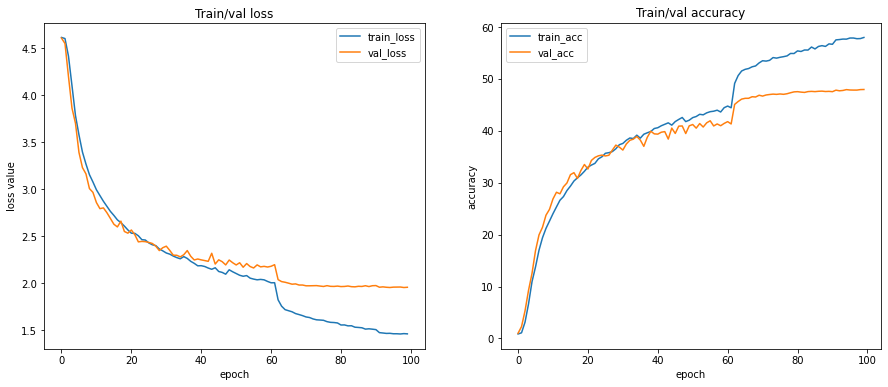

In [18]:
# final model's performances & training curves
print(f'Average loss & accuracy after last training epoch (n° {n_epochs_fm}):')
print(f'Train average loss: {round(train_losses_fm[-1],4)}, accuracy: {round(train_accuracies_fm[-1],4)}')
print(f'Validation average loss: {round(val_losses_fm[-1],4)}, accuracy: {round(val_accuracies_fm[-1],4)}')
plot(n_epochs_fm, train_losses_fm, val_losses_fm, train_accuracies_fm, val_accuracies_fm)

## Task 5. Model Errors

In [0]:
from random import randrange
import matplotlib.pyplot as plt
import math
from torchvision.transforms import ToPILImage

inverse_normalize = Normalize(mean=(-0.5/0.5,), std=(1/0.5,))

def plot_model_errors(outputs_list, nb_errors_to_print=10):
    ncols = 4
    nrows = math.ceil(nb_errors_to_print/ncols)
    
    # plot one image of each class
    fig, axs = plt.subplots(nrows, ncols, figsize=(8,8))
    
    rdm_idx = randrange(0, len(outputs_list))
    nb_prints = 0
    for _, img, label, output in outputs_list[rdm_idx:]+outputs_list[:rdm_idx]:
        if label != output:
            plot = axs[nb_prints//ncols][nb_prints%ncols]
            
            # normalized tensor -> unnormalized tensor -> numpy array
            img = inverse_normalize(img)
            img = img.permute(1, 2, 0).cpu().numpy()
            
            # plot
            plot.imshow(img)
            plot.title.set_text(f'Lbl: {label}, Pred: {output}')
            nb_prints += 1
            if nb_prints >= nb_errors_to_print:
                break
    plt.tight_layout()
    
    # remove unused subplots
    overflow = (ncols * nrows) - nb_errors_to_print
    for i in range(ncols-1, ncols-overflow-1, -1):
        fig.delaxes(axs[nrows-1][i])
    plt.show()

In [20]:
# test the model
_, _, outputs_list = evaluate(final_model, val_dataloader_fm, loss_fn_fm, validation=True, output_results=True)

Validation average loss: 1.9542, accuracy: 47.955


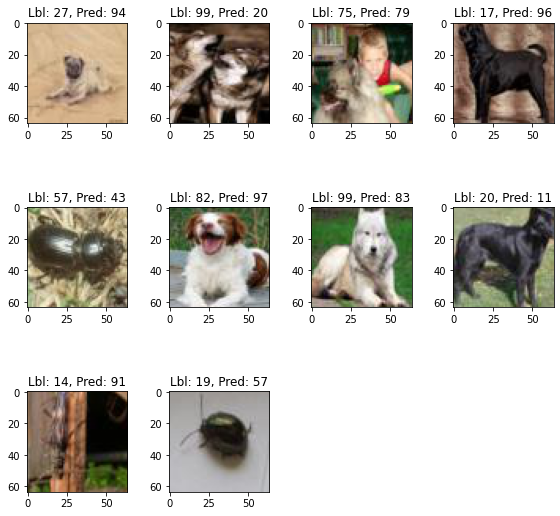

In [21]:
plot_model_errors(outputs_list)

### Report - model errors
<p>The model achieved ~48% accuracy on the validation set. Some errors the model made are easily justified as some images are difficult to classify even by humans (e.g. last image: classes 19 & 57 are both insects). However, image n°1 was miss-classified as a hyena where a human would have recognize a dog. The mistake here is maybe related to the background which could have similar colors as hyenas' natural habitat.</p>

## Task 6. Competition time!

In [22]:
import pandas as pd
test_dataset = ImageNetLimited('data/test', transforms=test_transforms, labels=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_fm, shuffle=False, num_workers=num_workers)
_, _, outputs_list = evaluate(final_model, test_dataloader, loss_fn_fm, validation=False, output_results=True)
predictions = [(img_name.item(), output.item()) for _, _, img_name, output in outputs_list]
predictions = sorted(predictions, key=lambda x: x[0])
df_predictions = pd.DataFrame(predictions, columns=["id", "label"])
df_predictions.to_csv('./data/Chacun.csv', index=False)
print('Predictions saved!')

Converting images & labels to tensors...
It took: 6.312638759613037 seconds
Predictions saved!
